# Visualización de datos Evoked

Este tutorial muestra los diferentes métodos de visualización para
objetos :class:`~mne.Evoked`.

Como de costumbre, comenzaremos importando los módulos que necesitamos:


In [1]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:

import numpy as np

import mne

En lugar de crear el objeto :class:`~mne.Evoked` a partir de un
objeto :class:`~mne.Epochs`, cargaremos un objeto :class:`~mne.Evoked`
existente desde el disco. Recuerda que el formato :file:`.fif` puede almacenar múltiples
objetos :class:`~mne.Evoked`, por lo que terminaremos con una `lista` de
objetos :class:`~mne.Evoked` después de la carga. Recuerda también de la
sección `tut-section-load-evk` del `tutorial introductorio sobre Evoked
<tut-evoked-class>` que los objetos de muestra :class:`~mne.Evoked` no han
sido corregidos para la línea base y tienen proyectores no aplicados, así que nos ocuparemos de eso al cargar:


In [3]:
root = "C:/Users/ulewi/mne_data/MNE-sample-data/MEG/sample"
evoked_file = "C:/Users/ulewi/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif"
evokeds_list = mne.read_evokeds(
    evoked_file, baseline=(None, 0), proj=True, verbose=False
)

# Show condition names and baseline intervals
for e in evokeds_list:
    print(f"Condition: {e.comment}, baseline: {e.baseline}")

Condition: Left Auditory, baseline: (-0.19979521315838786, 0.0)
Condition: Right Auditory, baseline: (-0.19979521315838786, 0.0)
Condition: Left visual, baseline: (-0.19979521315838786, 0.0)
Condition: Right visual, baseline: (-0.19979521315838786, 0.0)


Para facilitar nuestra tarea, vamos a convertir esa lista de objetos :class:`~mne.Evoked`
en un :class:`diccionario <dict>`. Usaremos claves de diccionario separadas por ``/`` para codificar las condiciones (como se hace a menudo cuando se están creando epochs) porque algunos de los métodos de trazado pueden aprovechar ese estilo de codificación.


In [4]:
conds = ("aud/left", "aud/right", "vis/left", "vis/right")
evks = dict(zip(conds, evokeds_list))
#      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ this is equivalent to:
# {'aud/left': evokeds_list[0], 'aud/right': evokeds_list[1],
#  'vis/left': evokeds_list[2], 'vis/right': evokeds_list[3]}

## Trazado de señales

.. admonition:: Gráficas de mariposa
   :class: sidebar note

   Las gráficas de series temporales de sensores superpuestas se llaman "gráficas de mariposa"
   porque las trazas que van en direcciones positiva y negativa pueden parecerse a las alas de una mariposa.

La gráfica más básica de objetos :class:`~mne.Evoked` es una gráfica de mariposa de
cada tipo de canal, generada por el método `evoked.plot() <mne.Evoked.plot>`.
Por defecto, los canales marcados como "malos" se suprimen, pero puedes
controlar esto pasando una :class:`lista` vacía al parámetro ``exclude``
(el valor por defecto es ``exclude='bads'``):


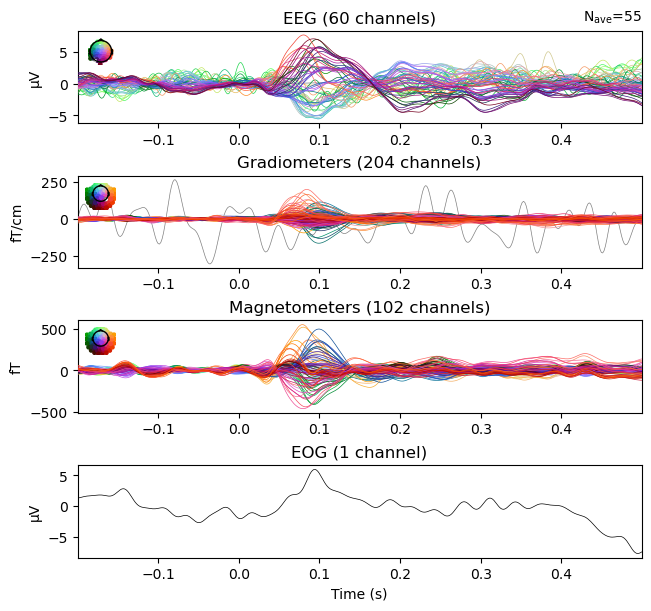

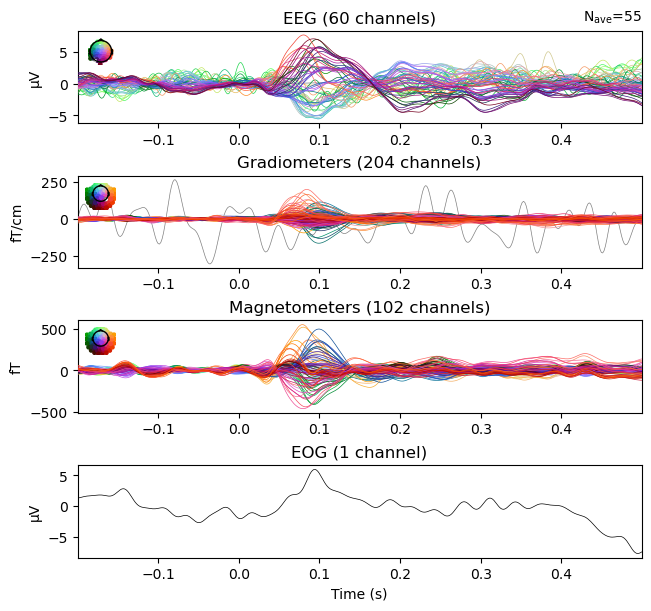

In [5]:
evks["aud/left"].plot(exclude=[])

Observa el canal EEG completamente plano y el canal de gradiómetro ruidoso
trazado en color rojo. Al igual que muchas funciones de trazado de MNE-Python,
`evoked.plot() <mne.Evoked.plot>` tiene un parámetro ``picks`` que puede
seleccionar canales para trazar por nombre, índice o tipo. En el siguiente gráfico, mostraremos
solo los canales de magnetómetro y también codificaremos las trazas de los canales por su
ubicación pasando ``spatial_colors=True``. Finalmente, superpondremos una
traza de la raíz cuadrada media (RMS) de la señal a través de los canales pasando
``gfp=True``. Este parámetro se llama ``gfp`` por razones históricas y se comporta correctamente para todos los tipos de canal soportados: para los datos MEG,
trazará el RMS; mientras que para EEG, trazará la
:term:`potencia de campo global <GFP>` (un RMS con referencia promedio), de ahí su
nombre:


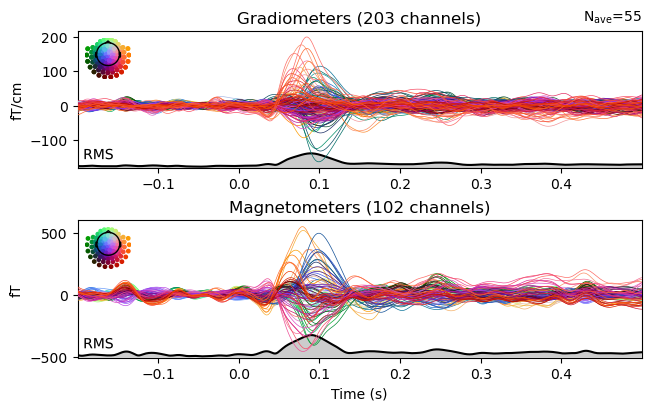

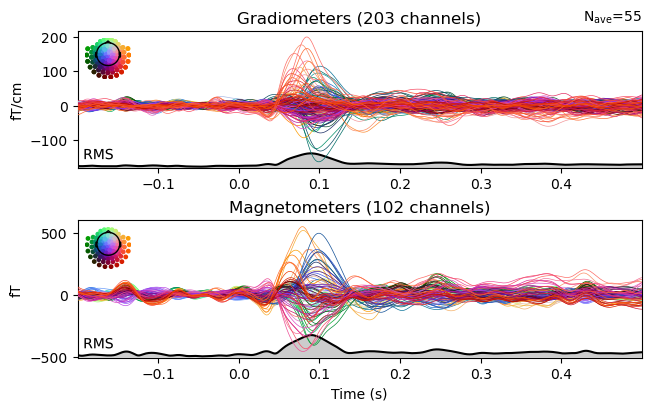

In [28]:
evks["aud/left"].plot(picks="meg", spatial_colors=True, gfp=True)

Los períodos de tiempo interesantes pueden ser destacados mediante el parámetro ``highlight``.


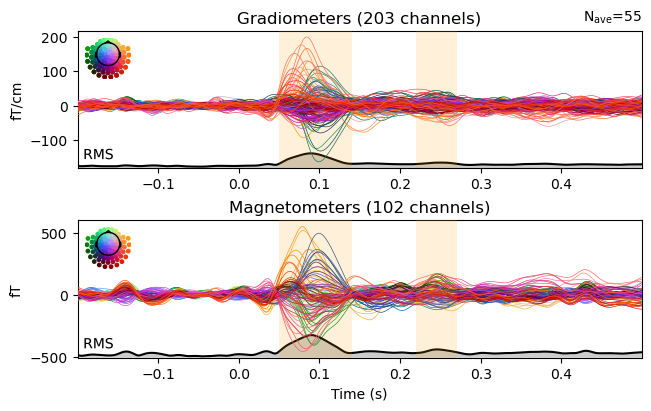

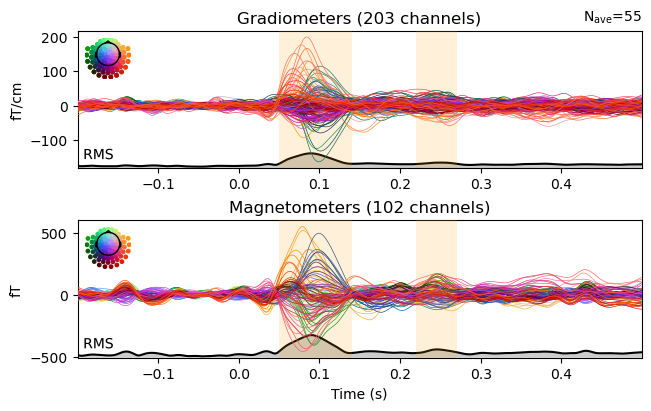

In [30]:
time_ranges_of_interest = [(0.05, 0.14), (0.22, 0.27)]
evks["aud/left"].plot(
    picks="meg", spatial_colors=True, gfp=True, highlight=time_ranges_of_interest
)

## Trazado de topografías del cuero cabelludo

En una sesión interactiva, las gráficas de mariposa vistas anteriormente pueden ser
seleccionadas haciendo clic y arrastrando para seleccionar una región de tiempo, lo que mostrará un mapa de la distribución promedio del campo sobre el cuero cabelludo para el período de tiempo seleccionado. También puedes
generar topografías del cuero cabelludo en momentos específicos o períodos de tiempo utilizando el método :meth:`~mne.Evoked.plot_topomap`:


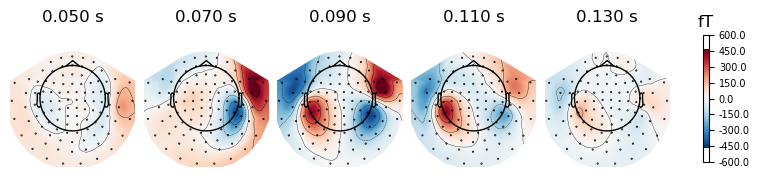

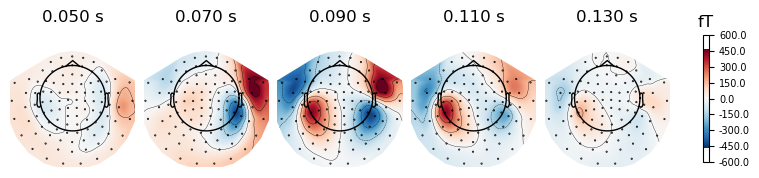

In [31]:
times = np.linspace(0.05, 0.13, 5)
evks["aud/left"].plot_topomap(ch_type="mag", times=times, colorbar=True)

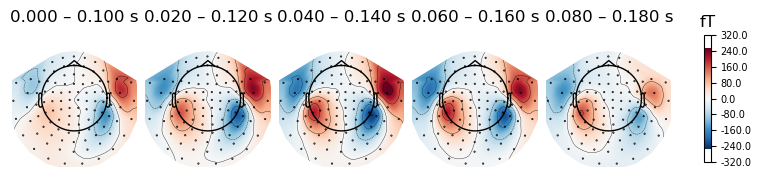

In [32]:
fig = evks["aud/left"].plot_topomap(ch_type="mag", times=times, average=0.1)

También es posible pasar diferentes duraciones de tiempo para promediar en cada
punto temporal. Pasar un valor de ``None`` deshabilitará el promedio para ese
punto temporal:


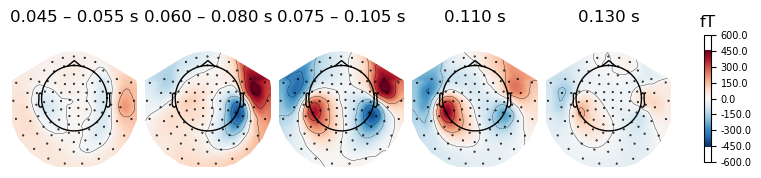

In [10]:
averaging_durations = [0.01, 0.02, 0.03, None, None]
fig = evks["aud/left"].plot_topomap(
    ch_type="mag", times=times, average=averaging_durations
)

Ejemplos adicionales de trazado de topografías del cuero cabelludo se pueden encontrar en
`ex-evoked-topomap`.

## Mapas de flechas

Las topografías del cuero cabelludo en un momento dado pueden ser aumentadas con flechas para mostrar
la magnitud estimada y la dirección del campo magnético, utilizando la
función :func:`mne.viz.plot_arrowmap`:


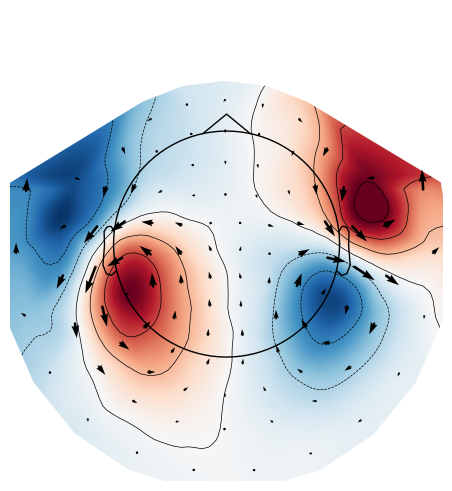

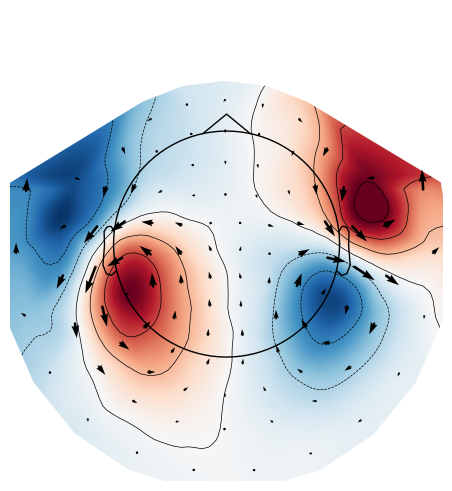

In [34]:
mags = evks["aud/left"].copy().pick(picks="mag")
mne.viz.plot_arrowmap(mags.data[:, 175], mags.info, extrapolate="local")

## Gráficas combinadas

Las gráficas combinadas combinan las gráficas de mariposa con las topografías del cuero cabelludo, y proporcionan una excelente primera vista de los datos evocados; por defecto, las topografías se colocarán automáticamente en función de la detección de picos. Aquí trazamos la condición del campo visual derecho; si no se especifican ``picks``, obtenemos una figura separada para cada tipo de canal:


Projections have already been applied. Setting proj attribute to True.


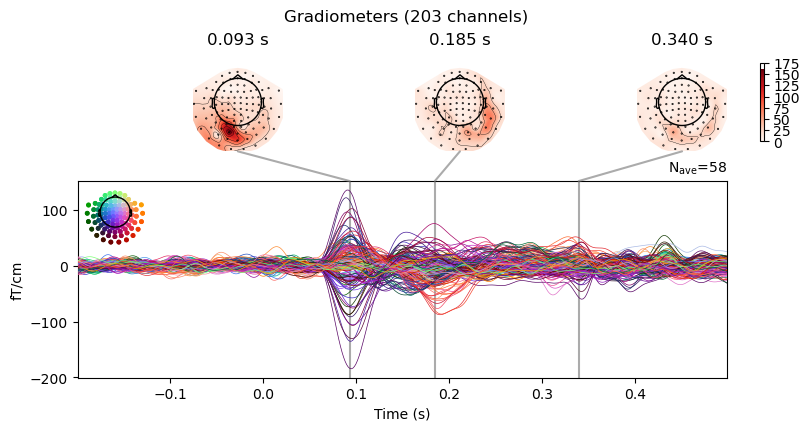

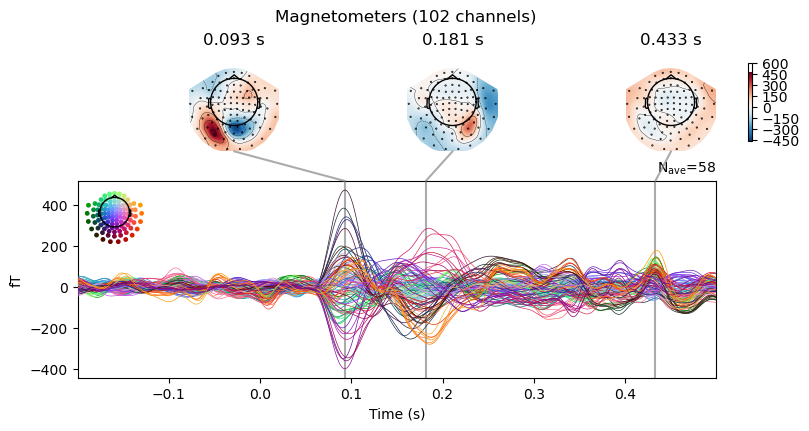

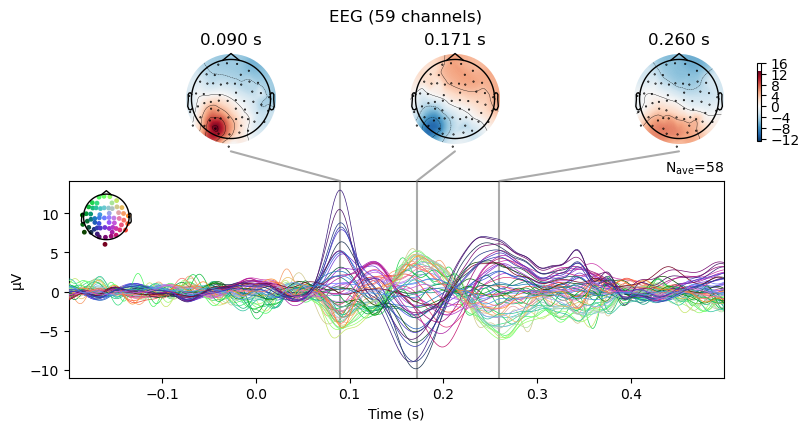

[<Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>]

In [12]:
evks["vis/right"].plot_joint()

Al igual que :meth:`~mne.Evoked.plot_topomap`, puedes especificar los ``times`` en los que
quieres que se calculen las topografías del cuero cabelludo, y puedes personalizar la gráfica de
varias otras maneras también. Consulta :meth:`mne.Evoked.plot_joint` para más detalles.

## Comparando objetos ``Evoked``

Para comparar objetos :class:`~mne.Evoked` de diferentes condiciones experimentales,
la función :func:`mne.viz.plot_compare_evokeds` puede tomar una
:class:`lista` o :class:`diccionario` de objetos :class:`~mne.Evoked` y trazarlos
todos en los mismos ejes. Al igual que la mayoría de las funciones de visualización de MNE-Python, tiene un
parámetro ``picks`` para seleccionar canales, pero por defecto generará una
figura para cada tipo de canal y combinará la información entre canales del
mismo tipo calculando la :term:`potencia de campo global`. La información
también se puede combinar entre canales de otras maneras; se admite la combinación a través de
media, mediana o desviación estándar, y también se pueden utilizar funciones personalizadas,
como se muestra aquí:


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


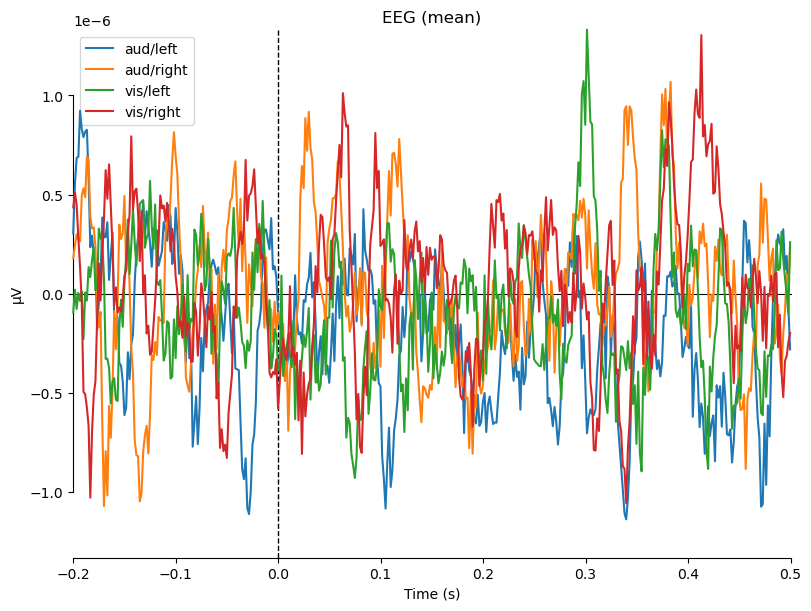

combining channels using "median"
combining channels using "median"
combining channels using "median"
combining channels using "median"


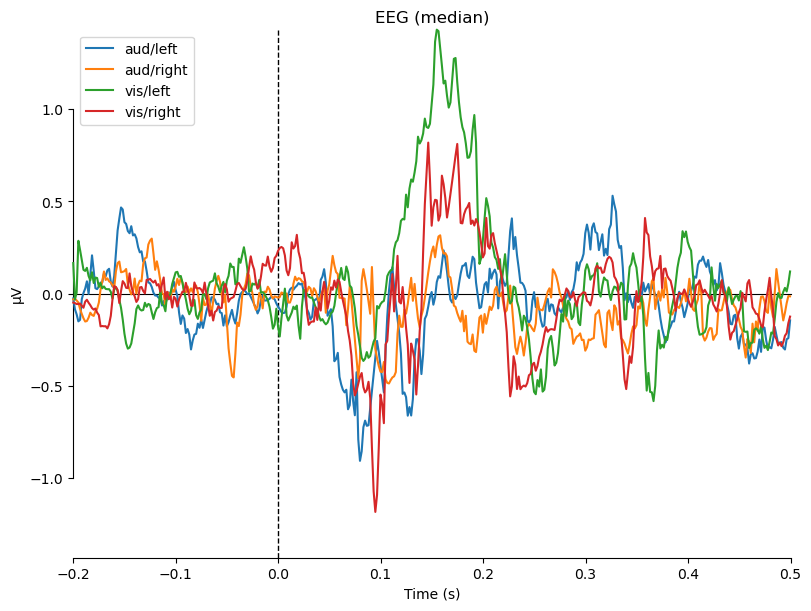

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


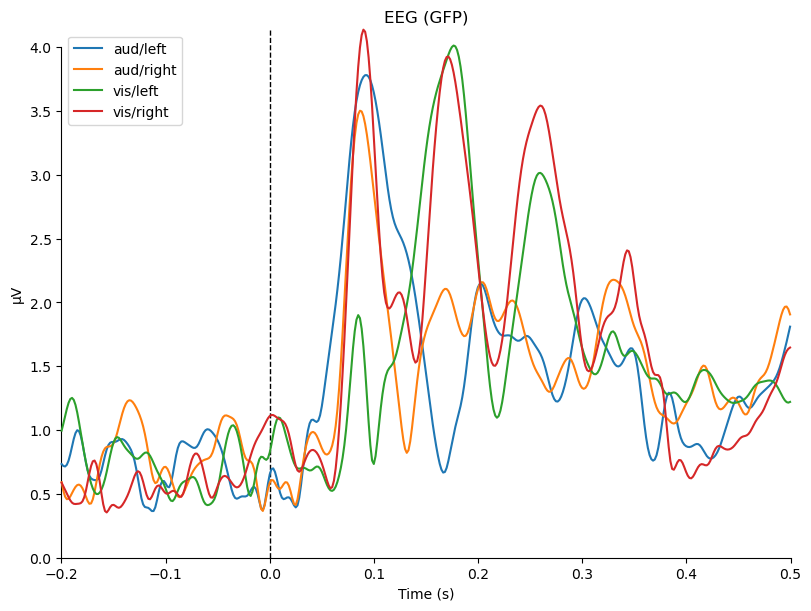

combining channels using "<function custom_func at 0x000001D0D09114E0>"
combining channels using "<function custom_func at 0x000001D0D09114E0>"
combining channels using "<function custom_func at 0x000001D0D09114E0>"
combining channels using "<function custom_func at 0x000001D0D09114E0>"


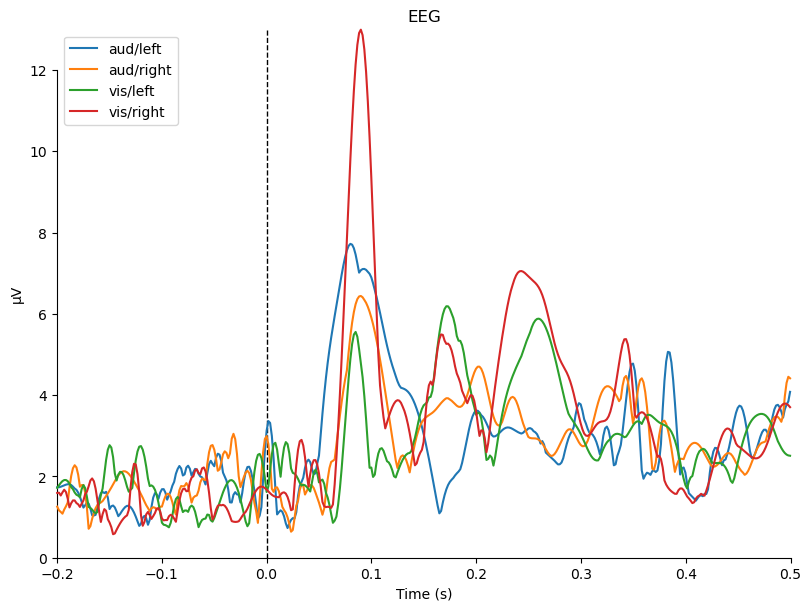

In [13]:
def custom_func(x):
    return x.max(axis=1)


for combine in ("mean", "median", "gfp", custom_func):
    mne.viz.plot_compare_evokeds(evks, picks="eeg", combine=combine)

Una característica interesante de :func:`~mne.viz.plot_compare_evokeds` es que al
pasar objetos evoked en un diccionario, permite especificar estilos de trazado basados en
subcadenas separadas por ``/`` de las claves del diccionario (similar a la selección de épocas; ver `tut-section-subselect-epochs`). Aquí, especificamos colores
para las condiciones "aud" y "vis", y estilos de línea para las condiciones "left" y "right",
y las trazas y la leyenda se estilizan en consecuencia. Aquí también mostramos el
parámetro ``time_unit='ms'`` en acción.


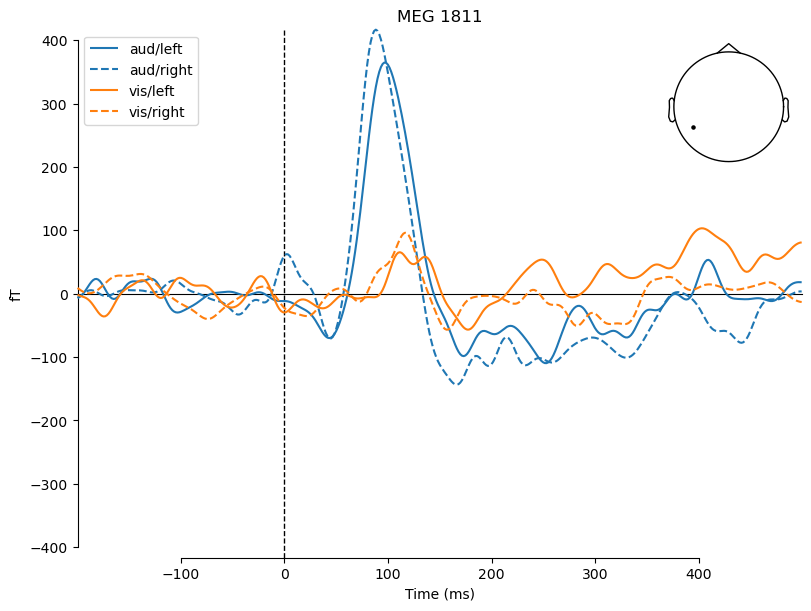

[<Figure size 800x600 with 2 Axes>]

In [14]:
mne.viz.plot_compare_evokeds(
    evks,
    picks="MEG 1811",
    colors=dict(aud=0, vis=1),
    linestyles=dict(left="solid", right="dashed"),
    time_unit="ms",
)

The legends generated by :func:`~mne.viz.plot_compare_evokeds` above used the
dictionary keys provided by the ``evks`` variable. If instead you pass a
:class:`list` or :class:`tuple` of :class:`~mne.Evoked` objects, the legend
keys will be generated automatically from the ``comment`` attribute of the
:class:`~mne.Evoked` objects (or, as sequential integers if the comment
attribute is empty or ambiguous). To illustrate this, we'll make a list of
five :class:`~mne.Evoked` objects: two with identical comments, two with
empty comments (either an empty string or ``None``), and one with a unique
non-empty comment:



combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


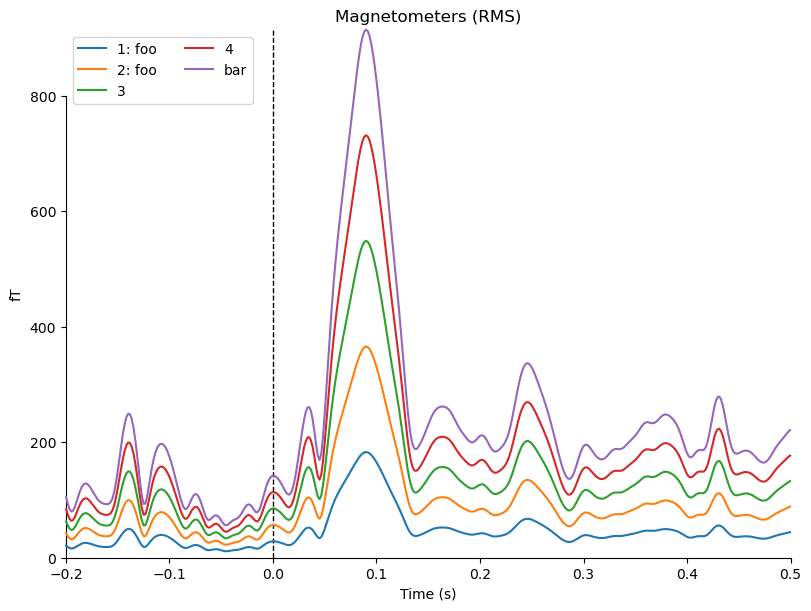

[<Figure size 800x600 with 1 Axes>]

In [15]:
temp_list = list()
for idx, _comment in enumerate(("foo", "foo", "", None, "bar"), start=1):
    _evk = evokeds_list[0].copy()
    _evk.comment = _comment
    _evk.data *= idx  # so we can tell the traces apart
    temp_list.append(_evk)

mne.viz.plot_compare_evokeds(temp_list, picks="mag")

## Image plots

Like :class:`~mne.Epochs`, :class:`~mne.Evoked` objects also have a
:meth:`~mne.Evoked.plot_image` method, but unlike `epochs.plot_image()
<mne.Epochs.plot_image>`, `evoked.plot_image() <mne.Evoked.plot_image>`
shows one *channel* per row instead of one *epoch* per row. Again, a
``picks`` parameter is available, as well as several other customization
options; see :meth:`~mne.Evoked.plot_image` for details.



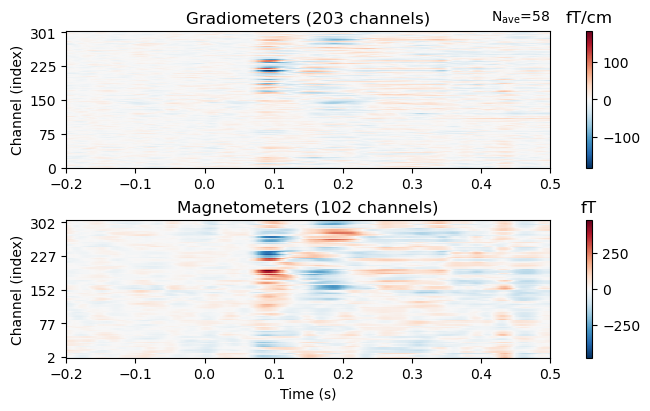

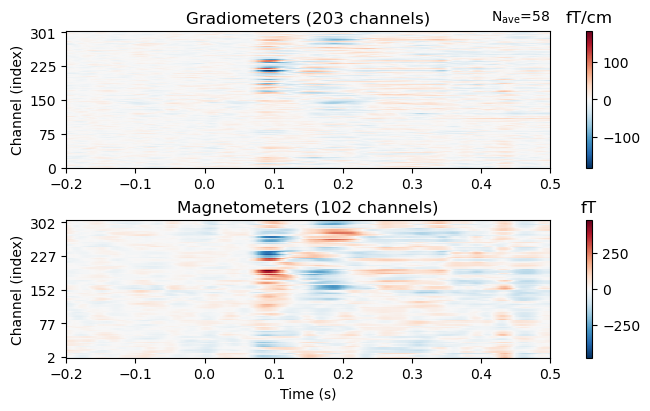

In [16]:
evks["vis/right"].plot_image(picks="meg")

## Topographical subplots

For sensor-level analyses, it can be useful to plot the response at each
sensor in a topographical layout. The :func:`~mne.viz.plot_compare_evokeds`
function can do this if you pass ``axes='topo'``, but it can be quite slow
if the number of sensors is too large, so here we'll plot only the EEG
channels:



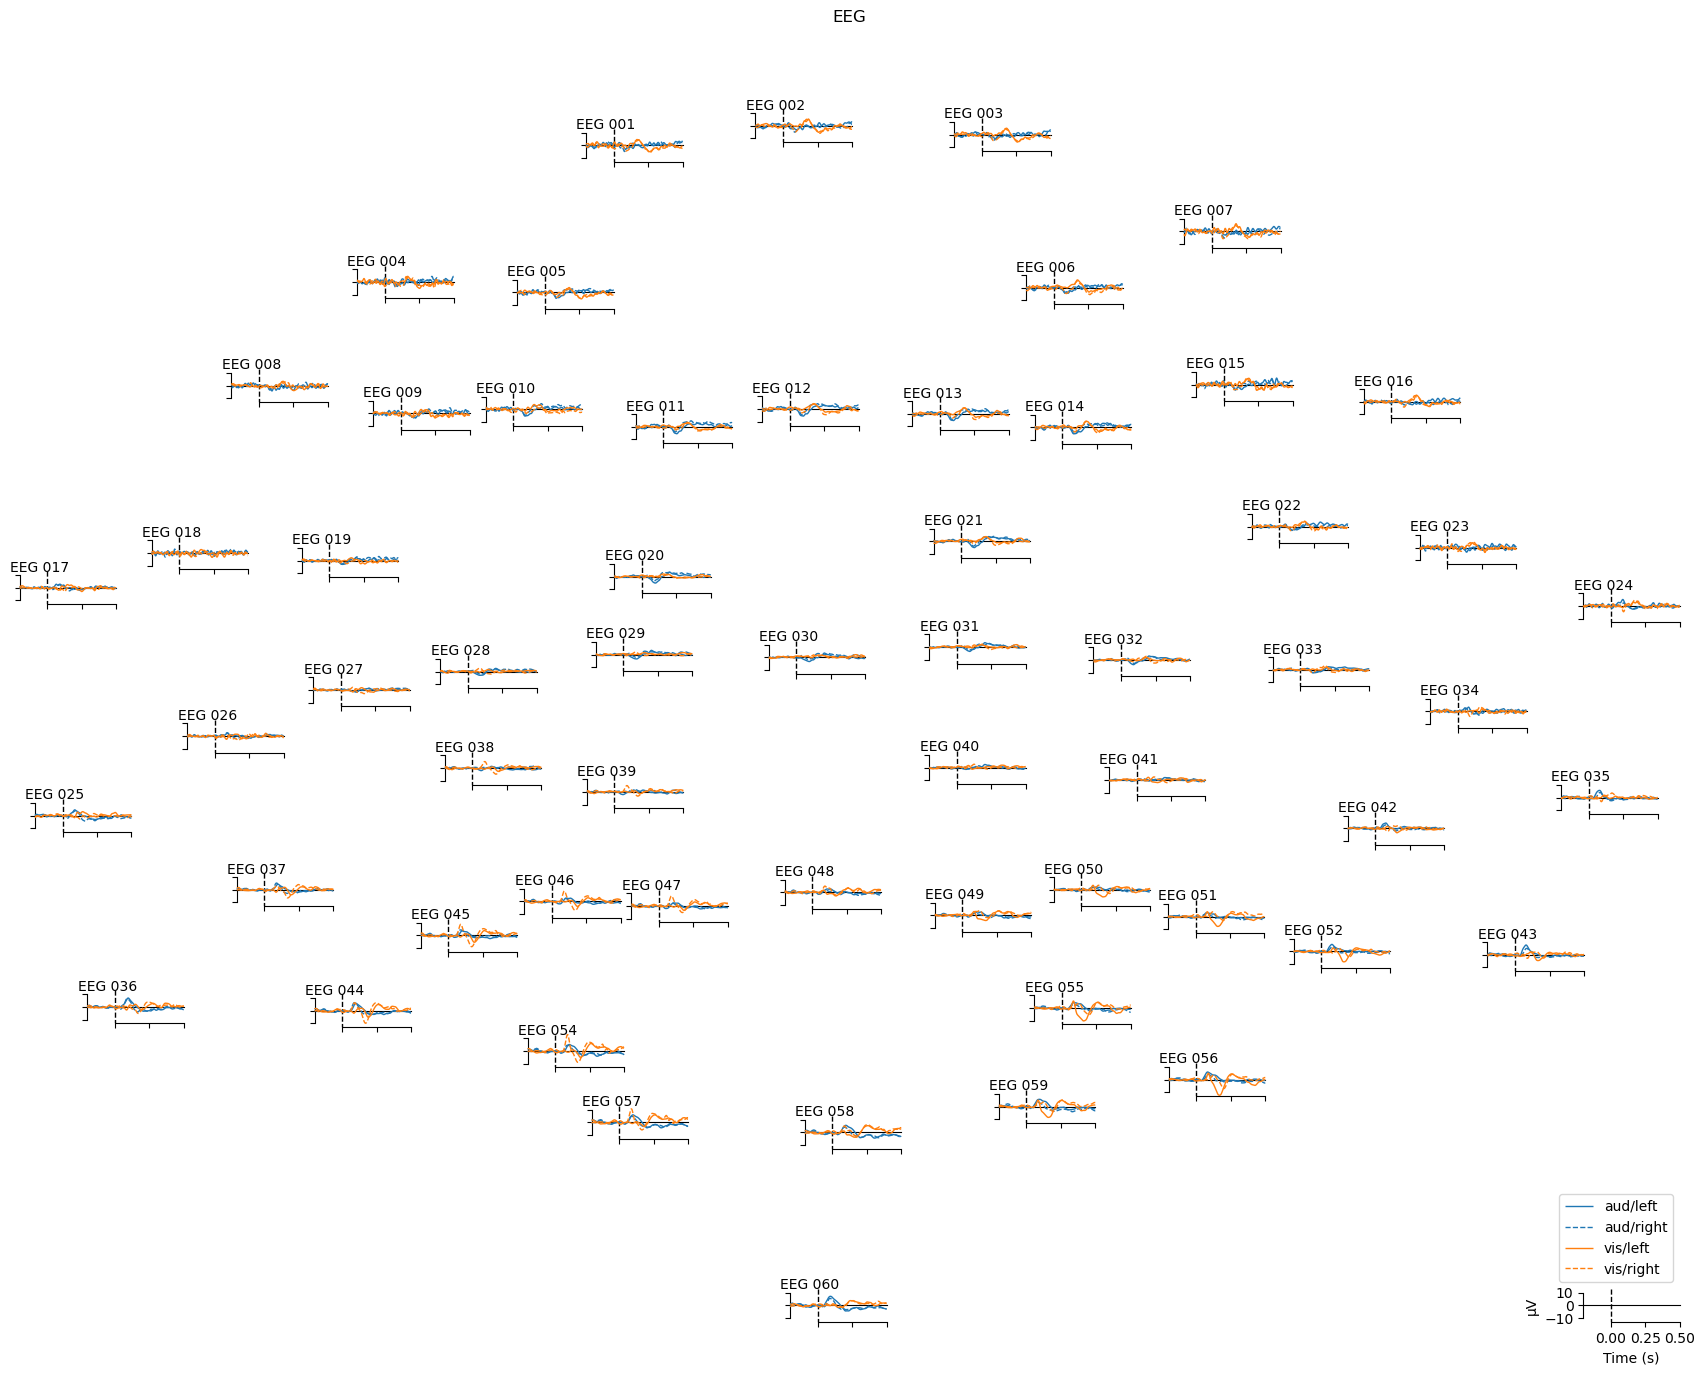

[<Figure size 1800x1400 with 60 Axes>]

In [17]:
mne.viz.plot_compare_evokeds(
    evks,
    picks="eeg",
    colors=dict(aud=0, vis=1),
    linestyles=dict(left="solid", right="dashed"),
    axes="topo",
    styles=dict(aud=dict(linewidth=1), vis=dict(linewidth=1)),
)

For a larger number of sensors, the method `evoked.plot_topo()
<mne.Evoked.plot_topo>` and the function :func:`mne.viz.plot_evoked_topo`
can both be used. The :meth:`~mne.Evoked.plot_topo` method will plot only a
single condition, while the :func:`~mne.viz.plot_evoked_topo` function can
plot one or more conditions on the same axes, if passed a list of
:class:`~mne.Evoked` objects. The legend entries will be automatically drawn
from the :class:`~mne.Evoked` objects' ``comment`` attribute:



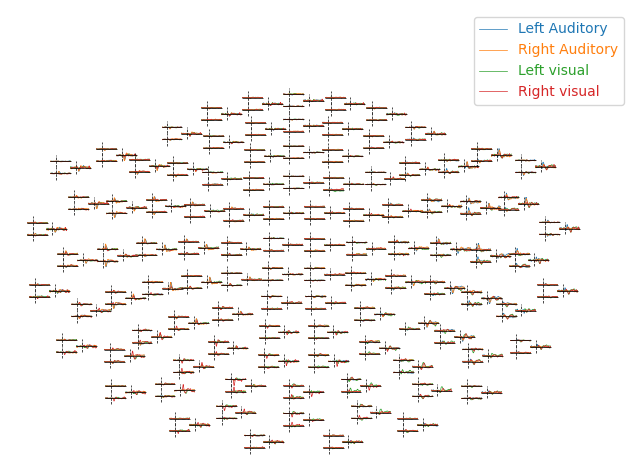

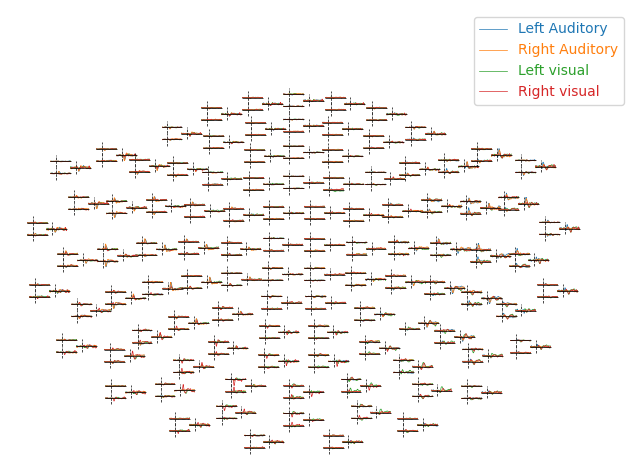

In [18]:
mne.viz.plot_evoked_topo(evokeds_list)

By default, :func:`~mne.viz.plot_evoked_topo` will plot all MEG sensors (if
present), so to get EEG sensors you would need to modify the evoked objects
first (e.g., using `mne.pick_types`).

<div class="alert alert-info"><h4>Note</h4><p>In interactive sessions, both approaches to topographical plotting allow
    you to click one of the sensor subplots to open a larger version of the
    evoked plot at that sensor.</p></div>


## 3D Field Maps

The scalp topographies above were all projected into two-dimensional overhead
views of the field, but it is also possible to plot field maps in 3D. This
requires a :term:`trans` file to transform locations between the coordinate
systems of the MEG device and the head surface (based on the MRI). You *can*
compute 3D field maps without a ``trans`` file, but it will only work for
calculating the field *on the MEG helmet from the MEG sensors*.



In [19]:
subjects_dir = "C:/Users/ulewi/mne_data/MNE-sample-data/subjects"
trans_file = "C:/Users/ulewi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif"

By default, MEG sensors will be used to estimate the field on the helmet
surface, while EEG sensors will be used to estimate the field on the scalp.
Once the maps are computed, you can plot them with `evoked.plot_field()
<mne.Evoked.plot_field>`:



In [25]:
maps = mne.make_field_map(
    evks["aud/left"], trans=str(trans_file), subject="sample", subjects_dir=subjects_dir
)
evks["aud/left"].plot_field(maps, time=0.2)

Using surface from C:\Users\ulewi\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-5120-5120-bem.fif.
Getting helmet for system 306m
Prepare EEG mapping...
Computing dot products for 59 electrodes...
Computing dot products for 2562 surface locations...
Field mapping data ready
    Preparing the mapping matrix...
    Truncating at 21/59 components to omit less than 0.001 (0.00097)
    The map has an average electrode reference (2562 channels)
Prepare MEG mapping...
Computing dot products for 305 coils...
Computing dot products for 304 surface locations...
Field mapping data ready
    Preparing the mapping matrix...
    Truncating at 210/305 components to omit less than 0.0001 (9.9e-05)


You can also use MEG sensors to estimate the *scalp* field by passing
``meg_surf='head'``. By selecting each sensor type in turn, you can compare
the scalp field estimates from each.



In [26]:
for ch_type in ("mag", "grad", "eeg"):
    evk = evks["aud/right"].copy().pick(ch_type)
    _map = mne.make_field_map(
        evk,
        trans=str(trans_file),
        subject="sample",
        subjects_dir=subjects_dir,
        meg_surf="head",
    )
    fig = evk.plot_field(_map, time=0.1)
    mne.viz.set_3d_title(fig, ch_type, size=20)

Using surface from C:\Users\ulewi\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-5120-5120-bem.fif.
Prepare MEG mapping...
Computing dot products for 102 coils...
Computing dot products for 2562 surface locations...
Field mapping data ready
    Preparing the mapping matrix...
    Truncating at 57/102 components to omit less than 0.0001 (9.9e-05)
Using surface from C:\Users\ulewi\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-5120-5120-bem.fif.
Prepare MEG mapping...
Computing dot products for 203 coils...
Computing dot products for 2562 surface locations...
Field mapping data ready
    Preparing the mapping matrix...
    Truncating at 166/203 components to omit less than 0.0001 (9.7e-05)
Using surface from C:\Users\ulewi\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-5120-5120-bem.fif.
Prepare EEG mapping...
Computing dot products for 59 electrodes...
Computing dot products for 2562 surface locations...
Field mapping data ready
    Preparing the mapping ma